True
False


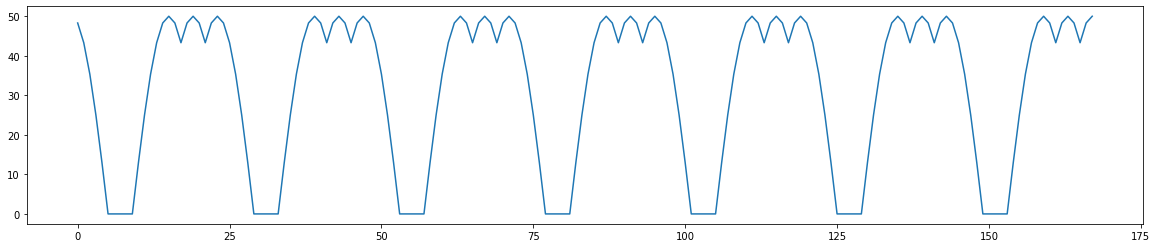

In [173]:
import random as rd
from PIL import Image
from PIL import ImageColor
import numpy as np
import matplotlib.pyplot as plt
import random

# This is the code for the random urban area generation
class map_maker:
    def __init__(self, size, sub_areas, noise_strength, wrong_patterns, wrong_patterns_strength):
        self.size = size
        self.noise_map = self.generate_noise(self.size,self.size)

        #strength of the noise used in the asignment of patterns
        self.noise_strength = noise_strength 

        # whether or not the wrong pattern noise should be used
        self.wrong_patterns = wrong_patterns
        self.wrong_patterns_strength = wrong_patterns_strength

        # amount of functional areas we want
        # thus equal to the amount of classes
        self.sub_areas = sub_areas

        # list with the class names
        self.sub_area_classes = [i for i in range(sub_areas)]

        # map with class for every building
        self.area_map = self.assign_class()

        # list which contains temporal pattern for every "building"
        self.pattern_map = self.fill_pattern_map()

        # dict with as key coordinates and as values the rgb color tuple
        self.color_map = self.create_color_map()



    def generate_noise(self, width, height):
        noise_map = []
        # Populate a noise map with 0s
        for y in range(height):
            new_row = []
            for x in range(width):
                new_row.append(0)
            noise_map.append(new_row)

        # Progressively apply variation to the noise map but changing values + or -
        # 5 from the previous entry in the same list, or the average of the
        # previous entry and the entry directly above
        new_value = 0
        top_of_range = 0
        bottom_of_range = 0
        for y in range(height):
            for x in range(width):
                if x == 0 and y == 0:
                    continue
                if y == 0:  # If the current position is in the first row
                    new_value = noise_map[y][x - 1] + rd.randint(-1000, +1000)
                elif x == 0:  # If the current position is in the first column
                    new_value = noise_map[y - 1][x] + rd.randint(-1000, +1000)
                else:
                    minimum = min(noise_map[y][x - 1], noise_map[y-1][x])
                    maximum = max(noise_map[y][x - 1], noise_map[y-1][x])
                    average_value = minimum + ((maximum-minimum)/2.0)
                    new_value = average_value + rd.randint(-1000, +1000)
                noise_map[y][x] = new_value
                # check whether value of current position is new top or bottom
                # of range
                if new_value < bottom_of_range:
                    bottom_of_range = new_value
                elif new_value > top_of_range:
                    top_of_range = new_value
        # Normalises the range, making minimum = 0 and maximum = 1
        difference = float(top_of_range - bottom_of_range)
        for y in range(height):
            for x in range(width):
                noise_map[y][x] = (noise_map[y][x] - bottom_of_range)/difference
        return noise_map


    # creates a color map based on the classes
    def create_color_map(self):
        noise_map = self.noise_map
        color_map = {}
        for i in range(len(noise_map)):
            for j in range(len(noise_map[i])):
                # area 1
                if self.area_map[i][j] == 0:
                    color = tuple([204,102,0])
                #area 2
                elif self.area_map[i][j] == 1:
                    color = tuple([153, 51, 255])
                else:
                    color = tuple([0,153,76])
                color_map[tuple([i,j])] = color
        return color_map


    # assigns a class to every value of the noise map
    # the amount of classes is determined by the initialization
    def assign_class(self):
        area_map = [[] for i in range(self.size)]
        for i in range(self.size):
            for j in range(self.size):
                area_map[i].append(0)

        #creates the boundaries for the sub areas
        boundaries = np.linspace(0,1, self.sub_areas + 1)

        # create bins where the values are [lower_bound, upperbound)
        # thus the lower_bound belongs to the bin but the upper bound does not
        bins = []
        for i in range(self.sub_areas):
            bins.append((boundaries[i], boundaries[i+1]))

        #iterate over every "building" in the map and assign a class
        for i in range(len(self.noise_map)):
            for j in range(len(self.noise_map[i])):
                for bin_number in range(len(bins)):
                    if self.noise_map[i][j] >= bins[bin_number][0] and self.noise_map[i][j] < bins[bin_number][1]:
                        area_map[i][j] = bin_number

                    # since the upperbound is not included, we need an edge case for the last upperbound (which is 1)
                    # we assign the last class to thiss area
                    if self.noise_map[i][j] == bins[self.sub_areas - 1][1]:
                        area_map[i][j] = self.sub_areas - 1

        
        return area_map

    def fill_pattern_map(self):
        pattern_map = [[] for i in range(self.size)]
        for i in range(self.size):
            for j in range(self.size):
                pattern_map[i].append([])

        #iterate over every "building" in the map and assign a class
        for i in range(len(self.area_map)):
            for j in range(len(self.area_map[i])):
                current_class = self.area_map[i][j]
                if self.wrong_patterns:
                    chance =np.random.rand()
                    if chance < self.wrong_patterns_strength:
                        if current_class == 0:
                            current_class = random.choice([1,2])
                        elif current_class == 1:
                            current_class = random.choice([0,2])
                        elif current_class == 2:
                            current_class = random.choice([0,1])

                pattern = self.assign_pattern(noise_strength=self.noise_strength, current_class=current_class)
                pattern_map[i][j] = pattern


        return pattern_map
       

    def assign_pattern(self, noise_strength=0, current_class=0):
        # supply 168 time points (represents one week)
        time_points = np.arange(0,168,1)

        # adjust the time points to radians for the sin function
        time_points_2 = time_points * ((2 * np.pi)/24)

        # create three types of standardized data
        if current_class == 0:
            # create points such that the shape resembles the original paper
            # we found that for the residential area, the maximum is around 50
            temp = 100 * np.sin(time_points_2 - (9 * ( np.pi/12)))
            temp_2 = 100 * np.sin(time_points_2 - (17 * ( np.pi/12)))

        if current_class == 1:
            # create points such that the shape resembles the original paper
            # we found that for the residential area, the maximum is around 50
            temp = 120 * np.sin(time_points_2 - (9 * ( np.pi/12)))
            temp_2 = 120 * np.sin(time_points_2 - (17 * ( np.pi/12)))

        if current_class == 2:
            # create points such that the shape resembles the original paper
            # we found that for the residential area, the maximum is around 50
            temp = 140 * np.sin(time_points_2 - (9 * ( np.pi/12)))
            temp_2 = 140 * np.sin(time_points_2 - (17 * ( np.pi/12)))

        # make sure that all values are above 0
        temp = np.where(temp < 0, 0, temp)
        temp_2 = np.where(temp_2 < 0, 0, temp_2)

        # the original data will be the mean of the previous two
        temp_3 = [np.mean([temp[i], temp_2[i]]) for i in range(len(temp))]

        # add the strength of our noise we want
        noise = np.random.normal(0,noise_strength,len(time_points))
        temp_4 = temp_3 + noise

        # again make sure that the value is never lower than 0
        temp_4 = np.where(temp_4 < 0, 0, temp_4)
        
        return temp_4


    def save_map(self, name):
        background = (0, 0, 0, 255)
        im = Image.new("RGB", (self.size,self.size), background)
        pixels = im.load()
        for i in range(len(self.noise_map)):
            for j in range(len(self.noise_map[i])):
                pixels[i,j] = self.color_map[tuple([i,j])]
        im.save(name + ".png", "PNG")




# size 100, 3 sub areas, 0 noise, no wrong patterns, no wrong pattern strength
newmap = map_maker(100, 3, 0, False, 0.0)

#print(newmap.area_map)


